In [1]:
#Calculates the number of Clenches in individual .csv file of EEG data caused by fluctuations in Electric Potential.

In [2]:
from scipy import fft, arange, signal
from scipy.special import logit, expit
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import os
import csv
import pandas as pd
from ttictoc import TicToc
#----------------------
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm, tree
import xgboost
from sklearn.model_selection import train_test_split
#---------------------RF HP-f(x) & CV---------------
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_val_score

In [3]:
EEG_FOLDER = "../../data/Clench/"

In [4]:
def read_file(path):
    """
    Reads the audio .wav file and returns the sample rate and data contents of the file.
    """
    sr, signal = wavfile.read(path)
    return sr, signal[:,0]

In [5]:
def read_all(files):
    """Branch audio file extrapolation. Uses read_file() method."""
    ret = []
    t = TicToc()
    t.tic();
    for fl in files:
        ret.append(read_file(fl))
    t.toc();
    print("Time it took to read data from files of length ", len(files), " = ", round(t.elapsed, 3), " seconds.")
    return np.array(ret)

In [6]:
def find_files(PATH, ext):
    """
    Finds all the files in a particular directory. Return only .csv files.
    """
    files = []
    for r, d, f in os.walk(PATH):
        for file in f:
            if ext in file:
                files.append(os.path.join(r, file).replace("\\","/"))
    return files

In [7]:
files = find_files(EEG_FOLDER, ".csv")

In [8]:
def remove_meta_data(PATH):
    """
    Return:
    1. Changes in Electric potential based on Unix timestamp from
        the 5 channels of the Emotiv headset. 2 channels from the Frontal Lobe, 
        1 channel from the parietal lobe, and 2 from temporal lobe.
    2. Pandas Dataframe of the data reflected from (1).
    """
    reader = csv.reader(open(PATH, "rt"), delimiter='\t')
    i = 0
    one_file_data = []
    for line in reader:
        if(i > 0):
            one_file_data.append(line)
        i += 1
    one_file_data = np.array(one_file_data)
    columns = one_file_data[0][0].split(",")[3:8]
    row_data = []
    for rows in one_file_data[1:]:
        dtx = rows[0].split(",")[3:8]
        cont = []
        for x in dtx:
            cont.append(float(x))
        row_data.append(cont)
    dataframe = pd.DataFrame(row_data, columns=columns)
    return np.array(row_data), dataframe

In [9]:
def data_DF_dir(list_PATH):
    """
    Returns all the data from a given set of path files and its associated pandas dataframe object.
    """
    raw_data = []
    dataframes = []
    for file in list_PATH:
        rd, dfob = remove_meta_data(file)
        raw_data.append(rd)
        dataframes.append(dfob)
    return raw_data, dataframes

In [10]:
bci_data, bci_df = data_DF_dir(files)

In [11]:
friendly_name = [x.split("/")[4].split("_")[0] for x in files]

In [12]:
def count_peaks_validation(peaks, x):
    count = 0
    for states in peaks:
        if(states > 500):
            count += 1
    plt.plot(x)
    plt.xlabel("Time (sample_rate (128) per second expansion)")
    plt.ylabel("Amplitude")
    plt.title("Time Domain Chart of Peak count (One-Sided f(x))", y=1.08)
    return count

In [13]:
def ease(index, distance):
    x = bci_data[index].T[0][120:]
    x = abs(x - np.average(x))  # biasing.
    peaks, props = signal.find_peaks(x, distance=distance)

    count = count_peaks_validation(peaks, x)
    return int(friendly_name[index]), count

In [14]:
def validation(distance, CV=False):
    
    validation_score = 0
    samples_correct = []
    samples_wrong = []
    
    for index in range(len(friendly_name)):
        test, pred = ease(index, distance)
        if(test == pred):
            validation_score += 1
            samples_correct.append(friendly_name[index])
        else:
            samples_wrong.append([friendly_name[index], pred])
    
    if(CV == False):
        print("Final Result :\n\nSamples Correct: ", str(validation_score), "\nSamples Incorrect : ", str(len(samples_wrong)), "\n")
        if(len(samples_wrong) > 0):
            for wr in range(len(samples_wrong)):
                print("Incorrect Sample #", str(wr+1), ": ", str(samples_wrong[wr][0]), "\tPredicted : ", str(samples_wrong[wr][1]))
    return validation_score, samples_correct, samples_wrong

Final Result :

Samples Correct:  13 
Samples Incorrect :  2 

Incorrect Sample # 1 :  003 	Predicted :  2
Incorrect Sample # 2 :  011 	Predicted :  14


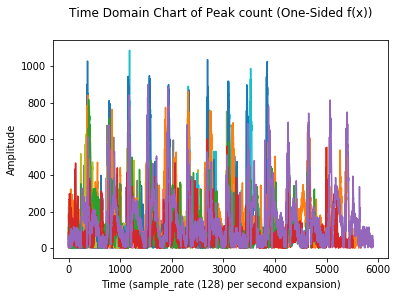

In [15]:
validation_score, correct, wrong = validation(270)

In [ ]:
highest = 0
high_index = 0
for cv in range(250, 350):
    print("Hit Count : ", cv)
    print("\nCurrent High Score : ", str(highest), "\tIndex : ", str(high_index))
    for x in range(0, 10):
        control = cv + (0.1*x)
        sc,_,_ = validation(control, True)
        if(sc > highest):
            highest = sc
            high_index = control

Hit Count :  250

Current High Score :  0 	Index :  0
Hit Count :  251

Current High Score :  12 	Index :  250.0
Hit Count :  252

Current High Score :  12 	Index :  250.0
Hit Count :  253

Current High Score :  12 	Index :  250.0
Hit Count :  254

Current High Score :  12 	Index :  250.0
Hit Count :  255

Current High Score :  12 	Index :  250.0
Hit Count :  256

Current High Score :  12 	Index :  250.0
Hit Count :  257

Current High Score :  12 	Index :  250.0
Hit Count :  258

Current High Score :  12 	Index :  250.0
Hit Count :  259

Current High Score :  12 	Index :  250.0
Hit Count :  260

Current High Score :  12 	Index :  250.0
Hit Count :  261

Current High Score :  12 	Index :  250.0
Hit Count :  262

Current High Score :  12 	Index :  250.0
Hit Count :  263

Current High Score :  12 	Index :  250.0
Hit Count :  264

Current High Score :  12 	Index :  250.0
Hit Count :  265

Current High Score :  12 	Index :  250.0
Hit Count :  266

Current High Score :  13 	Index :  265.1
Hi